In [1]:
import math
import tensorflow as tf
import numba as nb
from numba import njit, prange
import numpy as np
from numpy.random import rand

In [25]:
@njit(cache=True, parallel=True)
def mult(a, b, res):
    n = len(a)
    m = len(b)
    for i in prange(n):
        for j in range(m):
            res[i,j] = a[i]*b[j]

class Sigmoid:
    def __init__(self, n):
        self.n = n
        self.sigmoid = np.empty(n, dtype='float32')
    def calc(self, X):
        self.sigmoid = 1.0/(1.0+np.exp(-X))
        return self.sigmoid
    def grad(self, vec_top_grad):
        return vec_top_grad*self.sigmoid*(1.0-self.sigmoid)

class LeakyReLU:
    def __init__(self, n):
        self.n = n
        self.alpha = 0.1
        self.LeakyReLU = np.empty(n, dtype='float32')
    def calc(self, X):
        self.LeakyReLU = np.where(X>0,X, self.alpha*X)
        return self.LeakyReLU
    def grad(self, vec_top_grad):
        return vec_top_grad*np.where(self.LeakyReLU>0, 1.0, self.alpha)

In [2]:
class CrossEntropy:
    def __init__(self, num_classes, batch = 1, eps = 1e-8):
        self.num_classes = num_classes
        self.drop_grad = np.zeros(self.num_classes, dtype='float32')
        self.batch = batch
        self.eps = eps
    def calc(self, X, label):
        #print(X)
        self.X = X.clip(min=self.eps, max=1.0)
        #print(self.X)
        return -np.log(X[label])
    def grad(self, label):
        self.drop_grad.fill(0.0)
        self.drop_grad[label] = -1.0/self.X[label]
        return self.drop_grad
    
class SoftMax:
    def __init__(self, n):
        self.n = n
        self.tmp = np.empty((n,n), dtype='float32')
        self.softmax = np.empty(n, dtype='float32')
    def calc(self, X):
        print('x in softmax', max(X))
        self.softmax = np.exp(X)
        self.softmax /= np.sum(self.softmax)
        return self.softmax
    def grad(self, vec_top_grad):
        mult(-self.softmax, self.softmax, self.tmp)
        self.tmp[np.diag_indices_from(self.tmp)] = self.softmax*(1.0-self.softmax)
        return np.dot(vec_top_grad, self.tmp)
    
def initW(n_input, n_output):
    tmp1 = np.random.normal(0.0, 2.0/(n_input+n_output), size=n_input*n_output)
    tmp1 = tmp1.reshape(n_input,n_output).astype('float32')
    tmp2 = np.random.normal(0.0, 2.0/(n_output+n_output), size=n_output).astype('float32')
    return tmp1, tmp2

class Net:
    const_coeff = 0.5
    coeff = 0.5
    def __init__(self, layers, num_classes):
        self.layers = layers
        self.n_layers = len(layers)
        self.cross = CrossEntropy(num_classes)
    def calc(self, x):
        res = None
        for layer in self.layers:
            res = layer.calc(x)
            #print(res)
            x = res
        return res
    def get_class(self, x):
        res = self.calc(x)
        return np.argmax(res), res
    def fit(self, X, Y, n):
        Net.coeff = Net.const_coeff
        for it in range(n):
            print('EPOCH',it+1)
            for x,y in zip(X,Y):
                res = self.calc(x)
                # cross res
                self.cross.calc(res, y)
                gr = self.cross.grad(y)
                #print('cross-grad',max(abs(gr)))
                max_gr = max(abs(gr))
                for layer in reversed(self.layers):
                    gr = layer.grad(gr)
                    #print('grad',max(abs(gr)))
                    max_gr = max(max_gr, max(abs(gr)))
                Net.coeff *= 0.9
                #print('max_grad',max_gr)

In [3]:
class FullConnected:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.n_input = len(W)
        self.n_output = len(b)
        self.new_grad = np.zeros((self.n_input,self.n_output), dtype='float32')
        self.res = np.zeros(self.n_output, dtype='float32')
    def calc(self, x):
        self.x = x
        #vec(x)*matr(W)=vec(y)
        self.res = np.dot(x, self.W)
        self.res += self.b
        print('max W, b, res',np.max(self.W), np.max(self.b), np.max(self.res))
        return self.res
    def grad(self, vec_top_grad):
        # поиск производной выхода y по входу x: d(y)/d(x)
        next_grad = np.dot(self.W, vec_top_grad) #порядок умножения?
        
        # поиск производной по W
        mult(self.x, vec_top_grad, self.new_grad)
        self.W -= Net.coeff*self.new_grad #0.1 коэффициент градиентного спуска
        
        # поиск производной по b
        self.b -= Net.coeff*vec_top_grad
        return next_grad

In [4]:
num_classes = 4
cross = CrossEntropy(num_classes)

x = np.array([1.,0.5], dtype='float32')
label = 1
np.random.seed(0)
l1 = FullConnected(*initW(2,4))
l2 = FullConnected(*initW(4,num_classes))
softmax = SoftMax(num_classes)

net = Net([l1,l2, softmax],num_classes)
net.fit([x], [label], 10)
res = net.calc(x)
print(res)
cross.calc(res, label)

EPOCH 1
max W, b, res 0.7469644 0.36356837 1.0853066
max W, b, res 0.56743866 0.3831948 0.86027646
x in softmax 0.86027646
EPOCH 2
max W, b, res 0.59923625 0.22504447 0.94593054
max W, b, res 0.38492867 0.7732025 1.4644704
x in softmax 1.4644704
EPOCH 3
max W, b, res 0.6299235 0.3210662 1.1619794
max W, b, res 0.5296237 0.93698287 2.105098
x in softmax 2.105098
EPOCH 4
max W, b, res 0.67275286 0.38251776 1.3002454
max W, b, res 0.6214872 1.0160407 2.5296335
x in softmax 2.5296335
EPOCH 5
max W, b, res 0.7121374 0.4219023 1.3888606
max W, b, res 0.67879534 1.0601156 2.8139892
x in softmax 2.8139892
EPOCH 6
max W, b, res 0.7394201 0.44918498 1.4502467
max W, b, res 0.7179721 1.0883234 3.017518
x in softmax 3.017518
EPOCH 7
max W, b, res 0.75952095 0.46928582 1.4954736
max W, b, res 0.7466084 1.1080692 3.1711216
x in softmax 3.1711216
EPOCH 8
max W, b, res 0.774986 0.4847509 1.53027
max W, b, res 0.76852375 1.1227237 3.291481
x in softmax 3.291481
EPOCH 9
max W, b, res 0.7872585 0.4970233

0.03528273

In [5]:
import pickle
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
data = unpickle('data/data_batch_1')

In [19]:
from PIL import Image
print(data.keys())
start, end = 2, 3
img_ars = data[b'data'][start:end]
img_labels = data[b'labels'][start:end]
print(len(img_ars[0]))
print(type(img_ars[0]))
img_ars = img_ars
for img_ar,i in zip(img_ars, range(start,end)):
    img = Image.fromarray(np.transpose(np.reshape(img_ar,(3, 32,32)), (1,2,0)), 'RGB')
    img.save(str(i)+'.png')
print(img_labels)

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
3072
<class 'numpy.ndarray'>
[9]


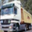

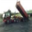

In [24]:
num_classes = 10
n_input = len(img_ars[0])

cross = CrossEntropy(num_classes)
x = (img_ars/255.0).astype('float32')
labels = img_labels
print(labels)
np.random.seed(0)
l1 = FullConnected(*initW(n_input, 256))
#leakyReLU = LeakyReLU(256)
l2 = FullConnected(*initW(256, num_classes))
softmax = SoftMax(num_classes)

net = Net([l1, l2, softmax],num_classes)
net.fit(x, labels, 10)
vx, vl = x[0], 0
calc_class, res = net.get_class(vx)
print('\n\nclass, res',calc_class, max(res), labels[0])
cross.calc(res, labels[vl])

[9]
EPOCH 1
max W, b, res 0.0028345326 0.015343387 0.061227813
max W, b, res 0.026923034 0.064989544 0.06586914
x in softmax 0.06586914
EPOCH 2
max W, b, res 0.01111435 0.018527998 10.792968
max W, b, res 0.035471484 0.33206314 8.240567
x in softmax 8.240567
EPOCH 3
max W, b, res 0.011135978 0.018541088 10.818428
max W, b, res 0.039393324 0.33272022 11.358049
x in softmax 11.358049
EPOCH 4
max W, b, res 0.01113665 0.018541435 10.819224
max W, b, res 0.03948948 0.33273625 11.43447
x in softmax 11.43447
EPOCH 5
max W, b, res 0.011137209 0.018541722 10.819875
max W, b, res 0.039568994 0.33274952 11.49766
x in softmax 11.49766
EPOCH 6
max W, b, res 0.011137678 0.018541962 10.820437
max W, b, res 0.03963552 0.3327606 11.550531
x in softmax 11.550531
EPOCH 7
max W, b, res 0.011138078 0.018542167 10.820899
max W, b, res 0.039691914 0.33277 11.59535
x in softmax 11.59535
EPOCH 8
max W, b, res 0.011138421 0.018542342 10.821302
max W, b, res 0.0397402 0.33277804 11.633727
x in softmax 11.633727


2.6285994e-05

In [18]:
class test:
    def __init__(self):
        self.x = np.array([1, 2, 3], dtype='float32')
    def get(self):
        return self.x
obj = test()
tmp = obj.get()
print(tmp)
tmp = [4]
print(tmp)
print(obj.x)

[1. 2. 3.]
[4]
[1. 2. 3.]
